# Super-resolution using Stable Diffusion v2 Upscalers

Tutorial to illustrate the task of super-resolution on medical images using Latent Diffusion Models (LDMs) [1] with models conditioned based on the signal-to-noise ratio (introduced on [2] and used in [Stable Diffusion v2.0](https://stability.ai/blog/stable-diffusion-v2-release) and Imagen Video [3]).

[1] - Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/abs/2112.10752
[2] - Ho et al. "Cascaded diffusion models for high fidelity image generation" https://arxiv.org/abs/2106.15282
[3] - Ho et al. "High Definition Video Generation with Diffusion Models" https://arxiv.org/abs/2210.02303

In [1]:
# TODO: Add buttom with "Open with Colab"

## Set up environment using Colab


In [2]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Set up imports

In [3]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()

/media/walter/Storage/Projects/GenerativeModels/venv-pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.1.dev2248
Numpy version: 1.24.1
Pytorch version: 1.8.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 3400bd91422ccba9ccc3aa2ffe7fecd4eb5596bf
MONAI __file__: /media/walter/Storage/Projects/GenerativeModels/venv-pytorch/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: 2.11.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.0+cu111
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, p

In [4]:
# for reproducibility purposes set a seed
set_determinism(42)

## Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpeb3sfuu7


## Download the training set

In [6]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "HeadCT"]

MedNIST.tar.gz: 59.0MB [00:04, 15.4MB/s]                                                                                                                                                                                       

2023-01-04 19:44:14,105 - INFO - Downloaded: /tmp/tmpeb3sfuu7/MedNIST.tar.gz


2023-01-04 19:44:14,178 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-01-04 19:44:14,179 - INFO - Writing into directory: /tmp/tmpeb3sfuu7.


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:13<00:00, 3503.78it/s]


## Create data loader for training set

Here, we create the data loader that we will use to train our models. We will use data augmentation and create low-resolution images using MONAI's transformations.

In [7]:
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
        transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
        transforms.Resized(keys=["low_res_image"], spatial_size=(16, 16)),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7991/7991 [00:04<00:00, 1965.12it/s]


## Visualise examples from the training set

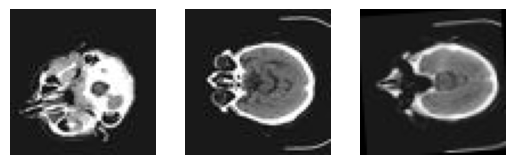

In [8]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for i in range(3):
    ax[i].imshow(check_data["image"][i, 0, :, :], cmap="gray")
    ax[i].axis("off")

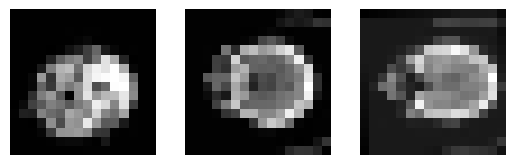

In [9]:
# Plot 3 examples from the training set in low resolution
fig, ax = plt.subplots(nrows=1, ncols=3)
for i in range(3):
    ax[i].imshow(check_data["low_res_image"][i, 0, :, :], cmap="gray")
    ax[i].axis("off")

## Create data loader for validation set

In [10]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "HeadCT"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
        transforms.Resized(keys=["low_res_image"], spatial_size=(16, 16)),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True, num_workers=4)

2023-01-04 19:44:36,765 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-01-04 19:44:36,766 - INFO - File exists: /tmp/tmpeb3sfuu7/MedNIST.tar.gz, skipped downloading.
2023-01-04 19:44:36,766 - INFO - Non-empty folder exists in /tmp/tmpeb3sfuu7/MedNIST, skipped extracting.


Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7991/7991 [00:07<00:00, 1049.69it/s]


## Define the network

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [12]:
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=256,
    latent_channels=3,
    ch_mult=(1, 2, 2),
    num_res_blocks=2,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
autoencoderkl = autoencoderkl.to(device)

In [13]:
discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    num_channels=64,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)

PatchDiscriminator(
  (initial_conv): Convolution(
    (conv): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (adn): ADN(
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (0): Convolution(
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): Convolution(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): Convolution(
    (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (adn): ADN(
      (N): Ba

In [14]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.002

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.005

optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=5e-5)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

In [15]:
scaler_g = GradScaler()
scaler_d = GradScaler()

## Train AutoencoderKL

Epoch 9: 100%|██████████████████| 250/250 [01:36<00:00,  2.60it/s, recons_loss=0.029, gen_loss=0, disc_loss=0]


epoch 10 val loss: 0.0282


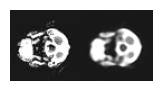

Epoch 19: 100%|████████| 250/250 [01:39<00:00,  2.51it/s, recons_loss=0.0219, gen_loss=0.345, disc_loss=0.232]


epoch 20 val loss: 0.0234


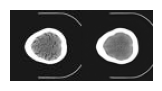

Epoch 29: 100%|████████| 250/250 [01:39<00:00,  2.51it/s, recons_loss=0.0191, gen_loss=0.348, disc_loss=0.223]


epoch 30 val loss: 0.0213


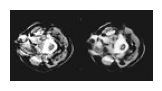

Epoch 39: 100%|████████| 250/250 [01:39<00:00,  2.51it/s, recons_loss=0.0177, gen_loss=0.327, disc_loss=0.236]


epoch 40 val loss: 0.0194


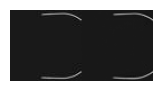

Epoch 49: 100%|████████| 250/250 [01:40<00:00,  2.50it/s, recons_loss=0.0159, gen_loss=0.311, disc_loss=0.235]


epoch 50 val loss: 0.0172


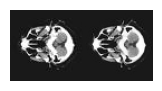

Epoch 59: 100%|████████| 250/250 [01:39<00:00,  2.50it/s, recons_loss=0.0149, gen_loss=0.306, disc_loss=0.239]


epoch 60 val loss: 0.0164


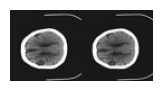

Epoch 69: 100%|█████████| 250/250 [01:40<00:00,  2.49it/s, recons_loss=0.0138, gen_loss=0.31, disc_loss=0.233]


epoch 70 val loss: 0.0145


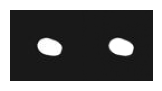

Epoch 74: 100%|█████████| 250/250 [01:40<00:00,  2.49it/s, recons_loss=0.0136, gen_loss=0.32, disc_loss=0.229]


In [16]:
kl_weight = 1e-6
n_epochs = 75
val_interval = 10
autoencoder_warm_up_n_epochs = 10

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            optimizer_d.zero_grad(set_to_none=True)

            with autocast(enabled=True):
                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                reconstruction, z_mu, z_sigma = autoencoderkl(images)
                recons_loss = F.l1_loss(images.float(), reconstruction.float())
                val_loss += recons_loss.item()

        val_loss /= val_step
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")

        # ploting reconstruction
        plt.figure(figsize=(2, 2))
        plt.imshow(torch.cat([images[0, 0].cpu(), reconstruction[0, 0].cpu()], dim=1), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

progress_bar.close()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

## Rescaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) became crucial in image-to-image translation models (such as the ones used for super-resolution). For this reason, we will compute the component-wise standard deviation to be used as scaling factor.

In [26]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1/torch.std(z)

Scaling factor set to 0.9804767370223999


## Train Diffusion Model

In order to train the super-resolution, we used the conditioned augmentation (introduced in [2] section 3 and used on Stable Diffusion Upscalers and Imagen Video [3] Section 2.5) as it has been shown critical for cascaded diffusion models, as well for super-resolution task. For this, we apply Gaussian noise augmentation given by a low_res_scheduler component, with the t step defining the signal-to-noise ratio and used to condition the diffusion model (inputted using class_labels argument). 

In [24]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(256, 256, 256, 512),
    attention_levels=(False, False, False, True),
    num_head_channels=32,
)

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    beta_start=0.0015,
    beta_end=0.0195,
)
low_res_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    beta_start=0.0015,
    beta_end=0.0195,
)

max_noise_level = 350

scaler_diffusion = GradScaler()

Epoch 19: 100%|█████████████████████████████████████████████████| 250/250 [00:31<00:00,  7.86it/s, loss=0.133]


Epoch 19 val loss: 0.1381


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.39it/s]
/media/walter/Storage/Projects/GenerativeModels/venv-pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


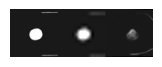

Epoch 39: 100%|█████████████████████████████████████████████████| 250/250 [00:31<00:00,  7.87it/s, loss=0.122]


Epoch 39 val loss: 0.1291


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.54it/s]
/media/walter/Storage/Projects/GenerativeModels/venv-pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


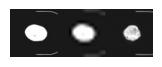

Epoch 59: 100%|█████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.81it/s, loss=0.125]


Epoch 59 val loss: 0.1269


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.10it/s]
/media/walter/Storage/Projects/GenerativeModels/venv-pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


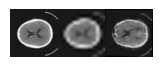

Epoch 79: 100%|█████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.79it/s, loss=0.121]


Epoch 79 val loss: 0.1274


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.35it/s]
/media/walter/Storage/Projects/GenerativeModels/venv-pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


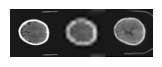

Epoch 99: 100%|█████████████████████████████████████████████████| 250/250 [00:31<00:00,  7.85it/s, loss=0.122]


Epoch 99 val loss: 0.1273


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.55it/s]
/media/walter/Storage/Projects/GenerativeModels/venv-pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


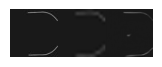

Epoch 119: 100%|████████████████████████████████████████████████| 250/250 [00:31<00:00,  7.82it/s, loss=0.122]


Epoch 119 val loss: 0.1239


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.67it/s]
/media/walter/Storage/Projects/GenerativeModels/venv-pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


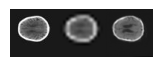

Epoch 139: 100%|████████████████████████████████████████████████| 250/250 [00:31<00:00,  7.86it/s, loss=0.115]


Epoch 139 val loss: 0.1202


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.16it/s]
/media/walter/Storage/Projects/GenerativeModels/venv-pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


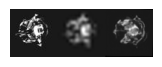

Epoch 159: 100%|████████████████████████████████████████████████| 250/250 [00:31<00:00,  7.86it/s, loss=0.114]


Epoch 159 val loss: 0.1195


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.41it/s]
/media/walter/Storage/Projects/GenerativeModels/venv-pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


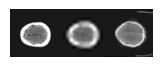

Epoch 179: 100%|████████████████████████████████████████████████| 250/250 [00:31<00:00,  7.87it/s, loss=0.111]


Epoch 179 val loss: 0.1165


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.17it/s]
/media/walter/Storage/Projects/GenerativeModels/venv-pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


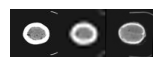

Epoch 199: 100%|████████████████████████████████████████████████| 250/250 [00:31<00:00,  7.82it/s, loss=0.115]


Epoch 199 val loss: 0.1192


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 30.11it/s]
/media/walter/Storage/Projects/GenerativeModels/venv-pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


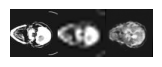

In [27]:
optimizer = torch.optim.Adam(unet.parameters(), lr=5e-5)

unet = unet.to(device)
n_epochs = 200
val_interval = 20
epoch_loss_list = []
val_epoch_loss_list = []

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        low_res_image = batch["low_res_image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            with torch.no_grad():
                latent = autoencoderkl.encode_stage_2_inputs(images) * scale_factor

            # Noise augmentation
            noise = torch.randn_like(latent).to(device)
            low_res_noise = torch.randn_like(low_res_image).to(device)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (latent.shape[0],), device=latent.device).long()
            low_res_timesteps = torch.randint(
                0, max_noise_level, (low_res_image.shape[0],), device=low_res_image.device
            ).long()

            noisy_latent = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
            noisy_low_res_image = scheduler.add_noise(
                original_samples=low_res_image, noise=low_res_noise, timesteps=low_res_timesteps
            )

            latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)

            noise_pred = unet(x=latent_model_input, timesteps=timesteps, class_labels=low_res_timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler_diffusion.scale(loss).backward()
        scaler_diffusion.step(optimizer)
        scaler_diffusion.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix(
            {
                "loss": epoch_loss / (step + 1),
            }
        )
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        for val_step, batch in enumerate(val_loader, start=1):
            images = batch["image"].to(device)
            low_res_image = batch["low_res_image"].to(device)

            with torch.no_grad():
                with autocast(enabled=True):
                    latent = autoencoderkl.encode_stage_2_inputs(images) * scale_factor
                    # Noise augmentation
                    noise = torch.randn_like(latent).to(device)
                    low_res_noise = torch.randn_like(low_res_image).to(device)
                    timesteps = torch.randint(
                        0, scheduler.num_train_timesteps, (latent.shape[0],), device=latent.device
                    ).long()
                    low_res_timesteps = torch.randint(
                        0, max_noise_level, (low_res_image.shape[0],), device=low_res_image.device
                    ).long()

                    noisy_latent = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
                    noisy_low_res_image = scheduler.add_noise(
                        original_samples=low_res_image, noise=low_res_noise, timesteps=low_res_timesteps
                    )

                    latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)
                    noise_pred = unet(x=latent_model_input, timesteps=timesteps, class_labels=low_res_timesteps)
                    loss = F.mse_loss(noise_pred.float(), noise.float())

            val_loss += loss.item()
        val_loss /= val_step
        val_epoch_loss_list.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training
        sampling_image = low_res_image[0].unsqueeze(0)
        latents = torch.randn((1, 3, 16, 16)).to(device)
        low_res_noise = torch.randn((1, 1, 16, 16)).to(device)
        noise_level = 20
        noise_level = torch.Tensor((noise_level,)).long().to(device)
        noisy_low_res_image = scheduler.add_noise(
            original_samples=sampling_image,
            noise=low_res_noise,
            timesteps=torch.Tensor((noise_level,)).long().to(device),
        )

        scheduler.set_timesteps(num_inference_steps=1000)
        for t in tqdm(scheduler.timesteps, ncols=110):
            with torch.no_grad():
                with autocast(enabled=True):
                    latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
                    noise_pred = unet(
                        x=latent_model_input, timesteps=torch.Tensor((t,)).to(device), class_labels=noise_level
                    )
                latents, _ = scheduler.step(noise_pred, t, latents)

        with torch.no_grad():
            decoded = autoencoderkl.decode_stage_2_outputs(latents / scale_factor)

        low_res_bicubic = nn.functional.interpolate(sampling_image, (64, 64), mode="bicubic")
        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(
            torch.cat([images[0, 0].cpu(), low_res_bicubic[0, 0].cpu(), decoded[0, 0].cpu()], dim=1),
            vmin=0,
            vmax=1,
            cmap="gray",
        )
        plt.tight_layout()
        plt.axis("off")
        plt.show()

### Plotting sampling example

In [51]:
# Sampling image during training
unet.eval()
num_samples = 3
validation_batch = first(val_loader)

images = validation_batch["image"].to(device)
sampling_image = validation_batch["low_res_image"].to(device)[:num_samples]

In [52]:
latents = torch.randn((num_samples, 3, 16, 16)).to(device)
low_res_noise = torch.randn((num_samples, 1, 16, 16)).to(device)
noise_level = 10
noise_level = torch.Tensor((noise_level,)).long().to(device)
noisy_low_res_image = scheduler.add_noise(
    original_samples=sampling_image,
    noise=low_res_noise,
    timesteps=torch.Tensor((noise_level,)).long().to(device),
)
scheduler.set_timesteps(num_inference_steps=1000)
for t in tqdm(scheduler.timesteps, ncols=110):
    with torch.no_grad():
        with autocast(enabled=True):
            latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
            noise_pred = unet(x=latent_model_input, timesteps=torch.Tensor((t,)).to(device), class_labels=noise_level)

        # 2. compute previous image: x_t -> x_t-1
        latents, _ = scheduler.step(noise_pred, t, latents)
        
with torch.no_grad():
    decoded = autoencoderkl.decode_stage_2_outputs(latents / scale_factor)

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.10it/s]


/media/walter/Storage/Projects/GenerativeModels/venv-pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


(-0.5, 191.5, 191.5, -0.5)

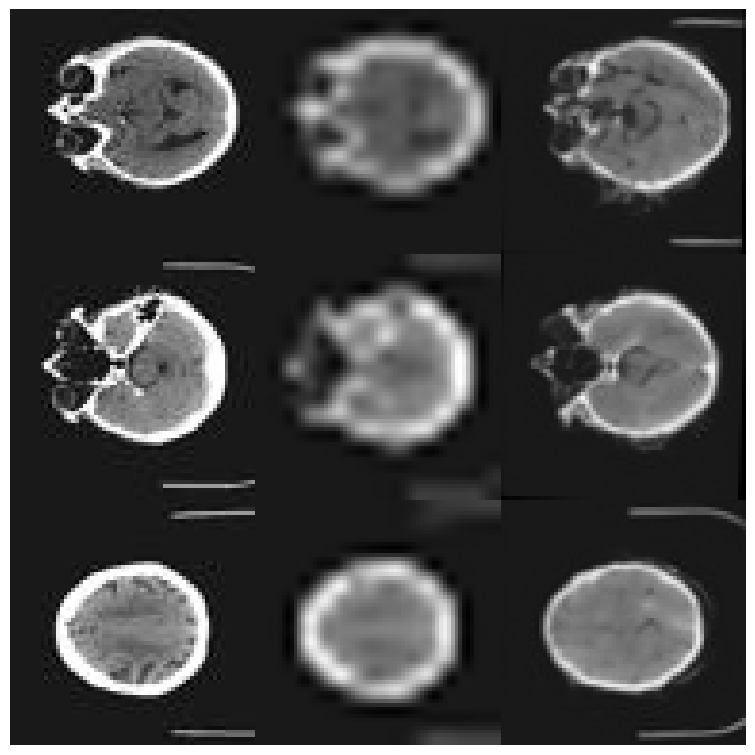

In [53]:
low_res_bicubic = nn.functional.interpolate(sampling_image, (64, 64), mode="bicubic")
plt.figure(figsize=(8, 8))
plt.style.use("default")
image_display = torch.cat([images[0, 0].cpu(), low_res_bicubic[0, 0].cpu(), decoded[0, 0].cpu()], dim=1)
for i in range(1, num_samples):
    image_display = torch.cat(
        [image_display, torch.cat([images[i, 0].cpu(), low_res_bicubic[i, 0].cpu(), decoded[i, 0].cpu()], dim=1)], dim=0
    )
plt.imshow(
    image_display,
    vmin=0,
    vmax=1,
    cmap="gray",
)
plt.tight_layout()
plt.axis("off")

### Clean-up data directory

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)